In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Segmenetación de nubes en base de datos de imágenes satelitales
El objetivo del siguiente proyecto es crear un algoritmo de segmentación de nubes para una base datos de imagenes satelitales el cual estaremos trabajando con la base de datos [Sentinel-2 Cloud Mask Catalogue](https://zenodo.org/record/4172871#.YRROGohKiHu) la cual cuenta con 513 imágenes satelitales, dentro de las cuales, algunas de ellas contienen una gran cantidad de nubes o ninguna.


In [ ]:
import os
import numpy as np 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from random import randint
import cv2
import skimage
import skimage.io
import skimage.morphology as morph
import skimage.color as color
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

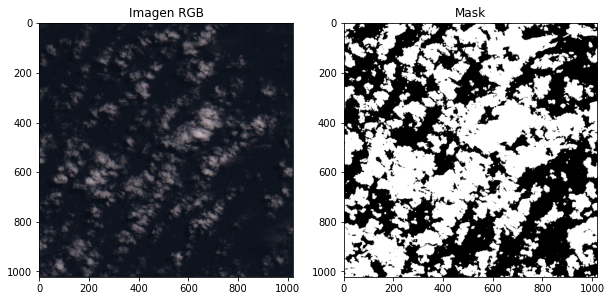

In [ ]:

path='S2B_MSIL1C_20181014T021339_N0206_R060_T50HLJ_20181014T061356.npy'

#Esto es para traer la mascara dimensiones (1022x1022x3)
pathmask='/content/drive/MyDrive/ProyectoVision/matriz/'+path
#Esto son las imagenes .npy (1022x1022x13)
pathsubscene='/content/drive/MyDrive/ProyectoVision/subscenes/'+path

mask = np.load(pathmask)
subscene=np.load(pathsubscene)

#Se transforma para que la imagen sea RGB
RGB=subscene[...,[3,2,1]]
#Se transforma mask de 1022x1022x3  a 1022x1022x1
mask=mask[:,:,1]

#Se muestra la imagen
fig, ((ax1, ax2) ) = plt.subplots(1,2 , figsize=(10, 5))
ax1.set_title("Imagen RGB")
ax2.set_title("Mask")
ax1.imshow(RGB)
ax2.imshow(mask, cmap="gray")


# Segmentación de las imágenes

Con base a la información dada por el catalogo de imágenes, encontramos que ellos ya tienen organizadas las imágenes y esta información se encuentra catalogada de la siguiente manera:   
* Tipo de suelo contiene 11 categorias.
* Tipo de nube contiene 7 categorias.
* Altura relativa de la nube contiene 2 categorias.
* Densidad de la nube contiene 2 categorias.
* Extención de la nube contiene 2 categorias.

Para más información la descripción del catalogo se encuenta en el siguiente link. [(información)](https://zenodo.org/record/4172871/files/README.pdf?download=1)

A continuación se abre la información anteriormente mencionada y se despliegan las 5 primeras filas que corresponden a 5 imágenes. 

In [ ]:
Classification_tags = pd.read_csv("/content/drive/MyDrive/ProyectoVision/classification_tags.csv")
Classification_tags.head()

index  ... contrails
0      0  ...         0
1      1  ...         0
2      2  ...         0
3      3  ...         0
4      4  ...         0

[5 rows x 33 columns]

In [ ]:
# El objetivo principal es crear mascaras a las imagenes que tengan un porcentaje de nubes diferente de 0 
# por lo que hay que segmentar las imagenes a utilizar
# A continuación se excluiran las imagenes que tienen como porcentaje de nubes igual a 0 
Database = list()
all_true = list()
Rest = []
for i in range(len(Classification_tags['cloud_percent'])):
  if Classification_tags['cloud_percent'][i] > float(25) and Classification_tags['cloud_percent'][i] < float(80) and Classification_tags['cloud_percent'][i] != float(100) :
    if Classification_tags['snow/ice'][i] != float(1):
      Database.append(Classification_tags['scene'][i] + '.npy')
    else:
      pass
    if Classification_tags['cloud_percent'][i] == float(100):
      all_true.append(Classification_tags['scene'][i] + '.npy')
    else:
      pass
  else:
    pass
# Encontramos que hay 386 imaganes con porcentaje de nubes diferente de 0 en la base de datos original
# y 194 imagenes que no son 100% nubes 
# spliting the data 
training_data = Database[:136]
test_data = Database[136:175]
validation_data = Database[175:194]

In [ ]:
print(f"porcentaje de muestras para la carpeta de training 70% {len(Database)*0.70}, {np.round(len(Database)*0.70,0)}")
print(f"porcentaje de muestras para la carpeta de test 20% {len(Database)*0.20}, {np.round(len(Database)*0.20,0)}")
print(f"porcentaje de muestras para la carpeta de validation 10% {len(Database)*0.10}, {np.round(len(Database)*0.10,0)}")
print(f"verificación {np.round(len(Database)*0.70,0) + np.round(len(Database)*0.20,0) + np.round(len(Database)*0.10,0)}")

porcentaje de muestras para la carpeta de training 70% 43.4, 43.0
porcentaje de muestras para la carpeta de test 20% 12.4, 12.0
porcentaje de muestras para la carpeta de validation 10% 6.2, 6.0
verificación 61.0


Path de Imagen:  S2B_MSIL1C_20181203T153619_N0207_R068_T18QWH_20181203T202253.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


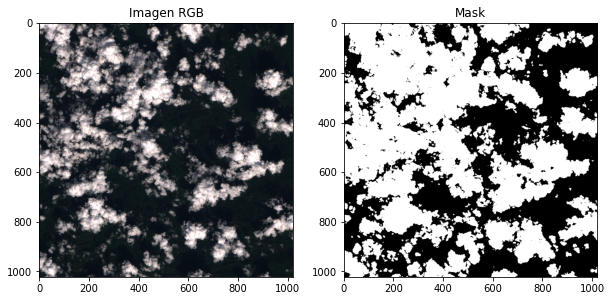

In [ ]:
path=Database[randint(0,len(Database))]
print("Path de Imagen:  " + path)

#Esto es para traer la mascara dimensiones (1022x1022x3)
pathmask='/content/drive/MyDrive/ProyectoVision/matriz/'+path
#Esto son las imagenes .npy (1022x1022x13)
pathsubscene='/content/drive/MyDrive/ProyectoVision/subscenes/'+path

mask = np.load(pathmask)
subscene=np.load(pathsubscene)

#Se transforma para que la imagen sea RGB
RGB=subscene[...,[3,2,1]]
#Se transforma mask de 1022x1022x3  a 1022x1022x1
mask=mask[:,:,1]

#Se muestra la imagen
fig, ((ax1, ax2) ) = plt.subplots(1,2 , figsize=(10, 5))
ax1.set_title("Imagen RGB")
ax2.set_title("Mask")
ax1.imshow(RGB)
ax2.imshow(mask, cmap="gray")

# Cambio de canales de color:
Se cambia el canal de color de RGB A LAB. El canal LAB nos perimite seleccionar el canal de iluminación, esto suponiendo que las nubes son las que mas ilumiación reflejan y asi poder umbralizar la imagen.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


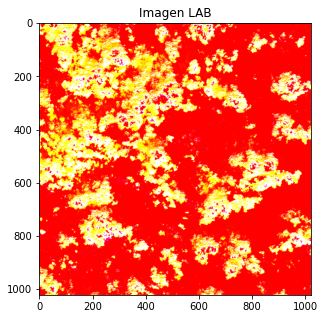

In [ ]:
#Se transforma la imagen de RGB a LAB
img_lab  = cv2.cvtColor(RGB, cv2.COLOR_RGB2LAB)
fig, ((ax1) ) = plt.subplots(1,1 , figsize=(10, 5))
ax1.set_title("Imagen LAB")
ax1.imshow(img_lab , cmap="gray" )


(1022, 1022, 3)


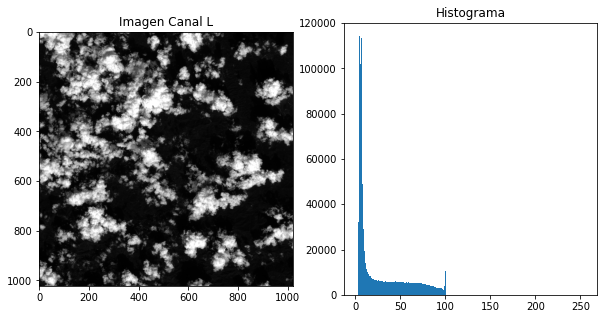

In [ ]:
#Se selecciona canal L 
img_L = img_lab[:,:,0]
img_A =  img_lab[:,:,1]
img_B = img_lab[:,:,2]
channelselect=img_L
print(img_lab.shape)
fig, ((ax1,ax2) ) = plt.subplots(1,2 , figsize=(10, 5))
ax1.set_title("Imagen Canal L")
ax2.set_title("Histograma")
ax1.imshow(channelselect, cmap="gray")
ax2.hist(channelselect.ravel(),256,[0,256]); plt.show()

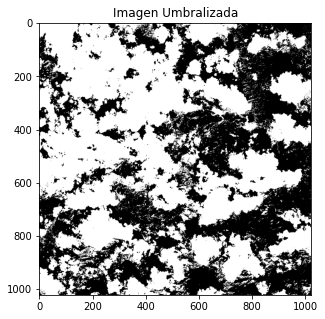

In [ ]:
#Se realiza la umbralizacion
ret,thresh = cv2.threshold(channelselect,8,40,cv2.THRESH_BINARY)
fig, ((ax1) ) = plt.subplots(1,1 , figsize=(10, 5))
ax1.set_title("Imagen Umbralizada")
ax1.imshow(thresh, cmap="gray")

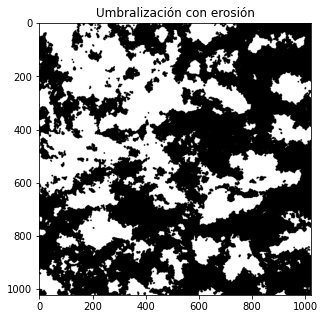

In [ ]:
#crear mascaras para aplicar erosion
elem1 = morph.disk(3)
erosion1 = morph.binary_erosion(thresh,elem1)
fig, ((ero) ) = plt.subplots(1,1 , figsize=(10, 5))
ero.set_title("Umbralización con erosión")
ero.imshow(erosion1, cmap="gray")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=4, use connectivity=1
  This is separate from the ipykernel package so we can avoid doing imports until


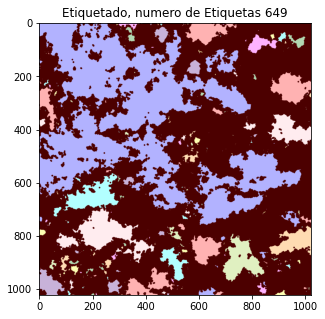

In [ ]:
#Etiquetado de imagenes

labels,num_labels = morph.label(erosion1,neighbors=4,return_num=True,connectivity=1)
image_label_overlay=color.label2rgb(labels,image=erosion1)
fig, ((etiquetado) ) = plt.subplots(1,1 , figsize=(10, 5))
etiquetado.set_title(f"Etiquetado, numero de Etiquetas {num_labels}")
etiquetado.imshow(image_label_overlay)


## **TensorFlow**

Para el desarrollo de este modelo fue necesario realizar la conversión de las imagenes a formato RGB ya que de esta manera la información es leida por la libreria de tesnsorflow, una vez se tiene la base de datos inicial en formato RGB se realiza una primera clasificación por medio de la información brindada por la base de datos se procede a realizar una inspección visual esto con el objetivo de tener una información clara para el entrenamiento del modelo.
[Código](https://colab.research.google.com/drive/1KW_u5cTtSRpfjw1SzjV8FRt4LwSgfes8?authuser=1#scrollTo=DJPQ2GN0O99Z)  

| Número de imagenes Analizadas  | 513 |
| ------------- | ------------- |
| Número de imagenes con nubes según el modelo  | 370  |
| Número de imagenes con sin nubes según el modelo  | 143  |

| Porcentaje de nubes | 72,12%|
|---|---|



In [ ]:
RGB_model = tf.keras.models.load_model('/content/drive/MyDrive/ProyectoVision/RGB_Data_JPG/saved_model/my_model')
# Check its architecture
RGB_model.summary()
# Evaluate the restored model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1020, 1020, 16)    448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 510, 510, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 508, 508, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 254, 254, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1016064)           0

In [ ]:
train = ImageDataGenerator (rescale = 1/255)
validation = ImageDataGenerator (rescale = 1/255)

test_dataset = train.flow_from_directory ('/content/drive/MyDrive/ProyectoVision/RGB_Data_JPG/data_test',
                                           target_size = (1022,1022),
                                           batch_size = 5,
                                           class_mode = 'binary')


loss, acc = RGB_model.evaluate(test_dataset, verbose=2)
print('RGB model, accuracy: {:5.2f}%'.format(100 * acc))
print(RGB_model.predict(test_dataset).shape)

Found 60 images belonging to 2 classes.
12/12 - 22s - loss: 0.2417 - accuracy: 0.9500
RGB model, accuracy: 95.00%
(60, 1)


In [ ]:
Classification_tags = pd.read_csv("/content/drive/MyDrive/ProyectoVision/RGB_Data_JPG/Clasificicación_modelo_RGB.csv", sep = ";")
Classification_tags.head(10)
print(Classification_tags.size)

2052


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

KeyboardInterrupt: ignored

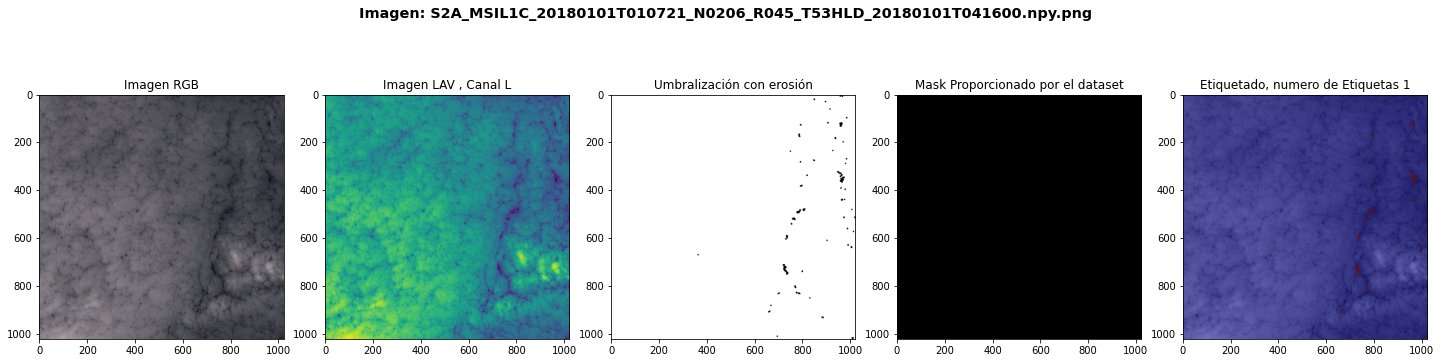

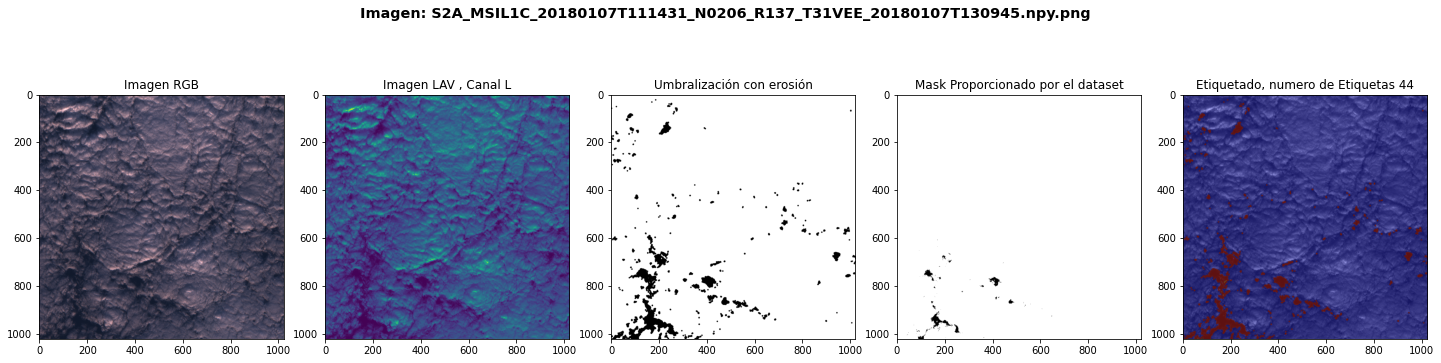

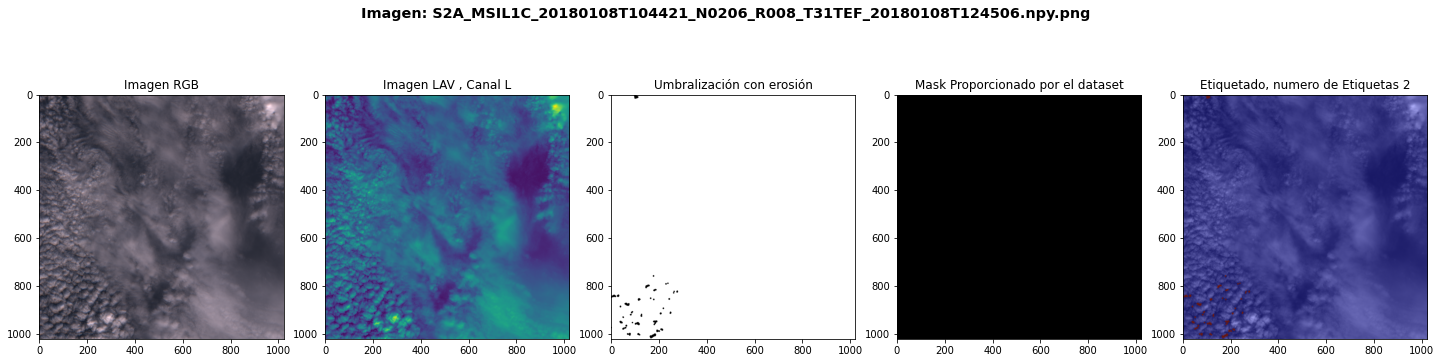

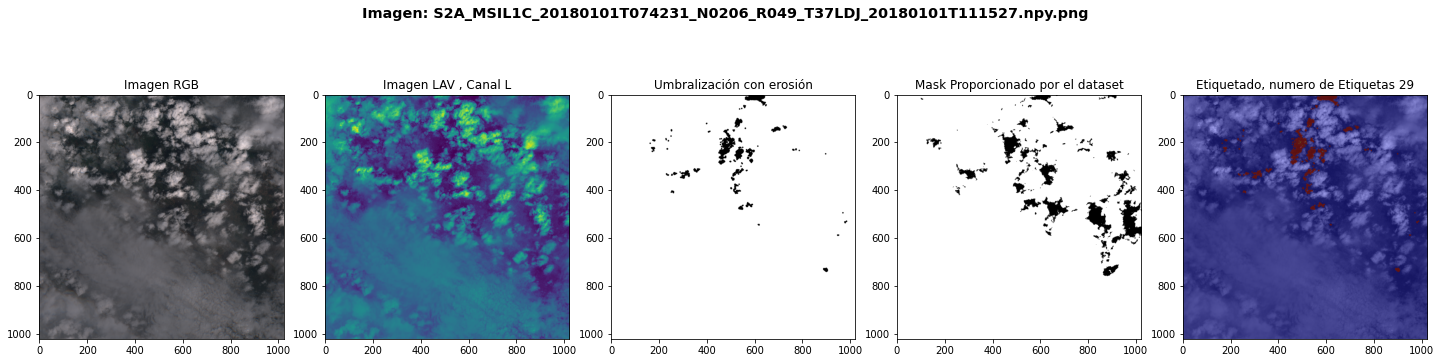

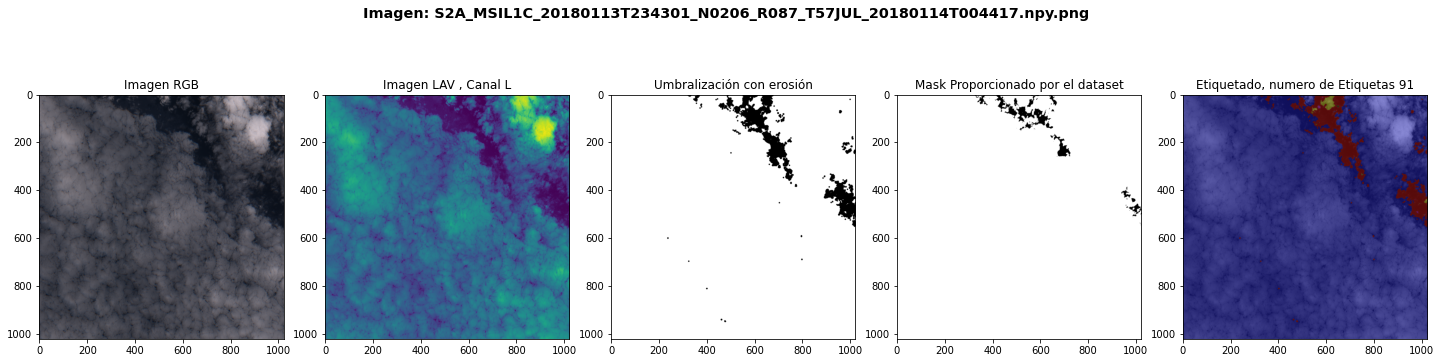

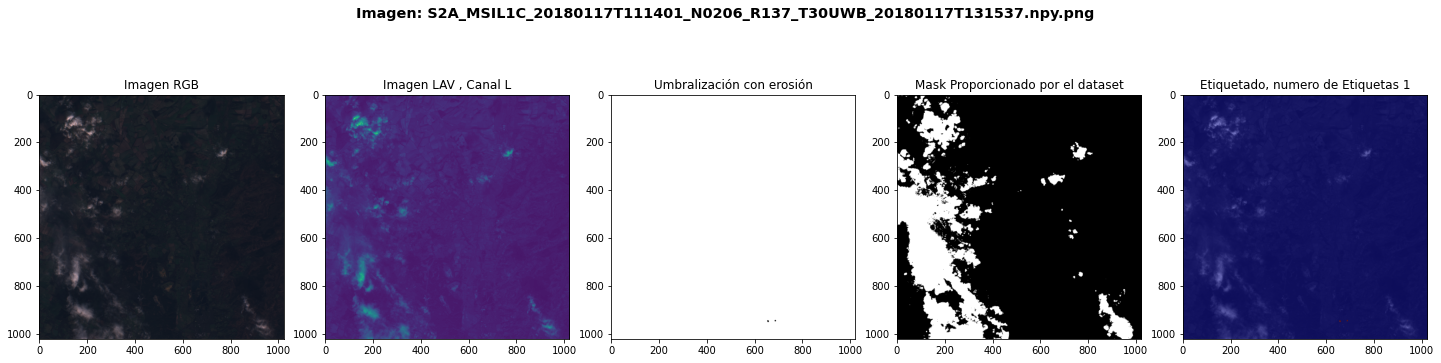

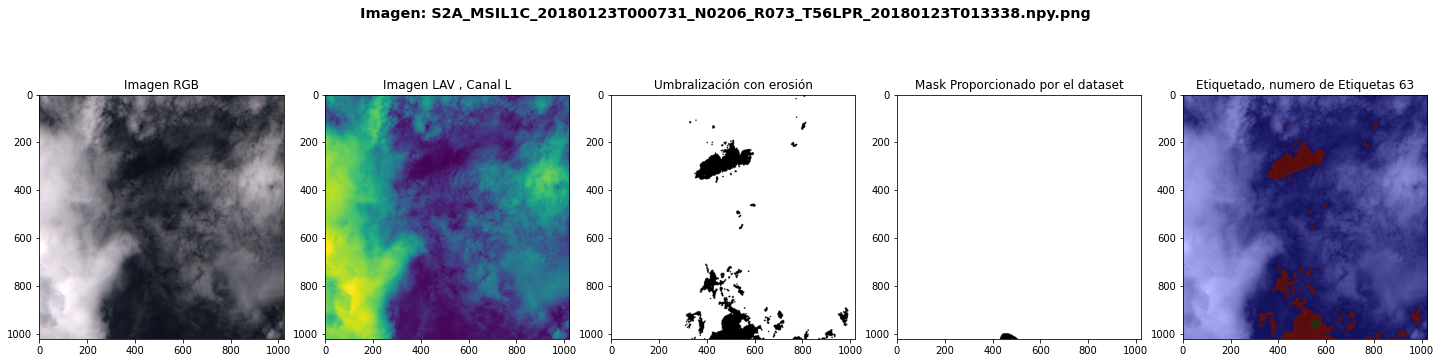

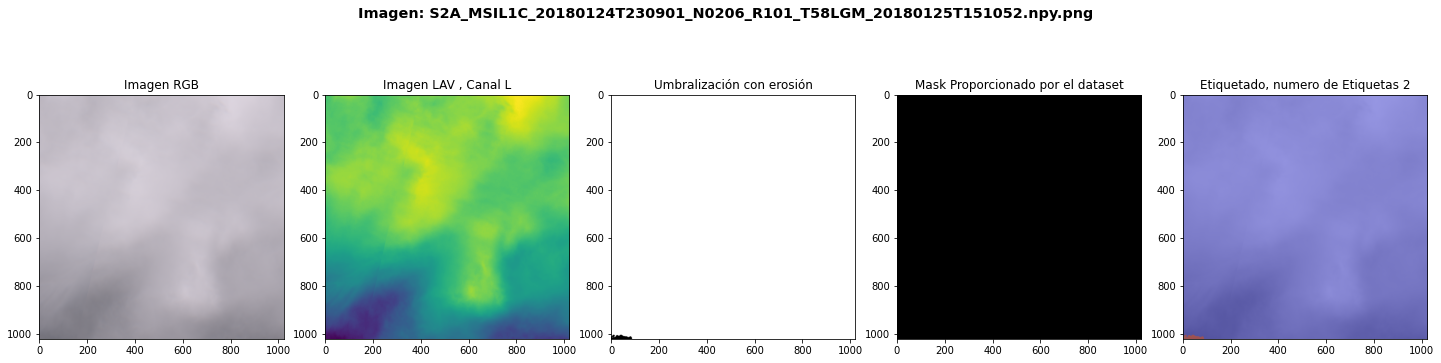

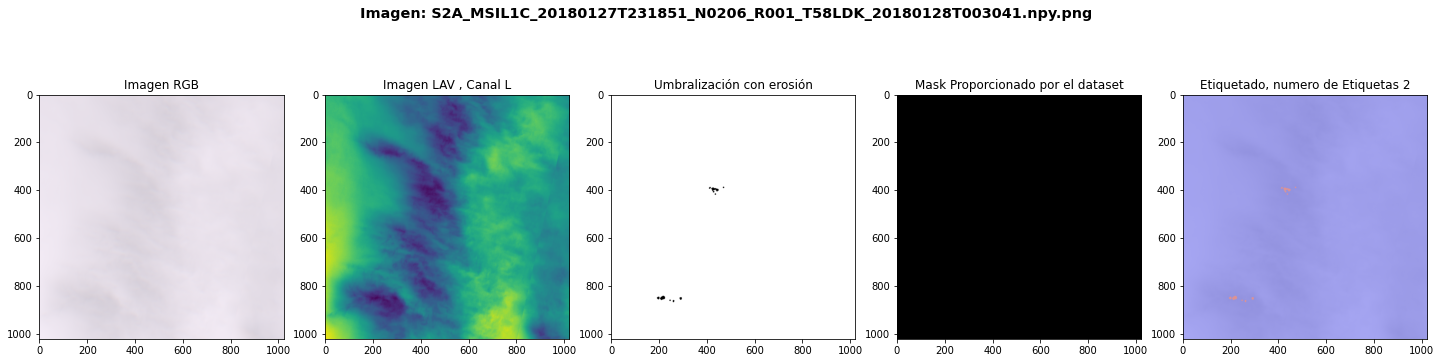

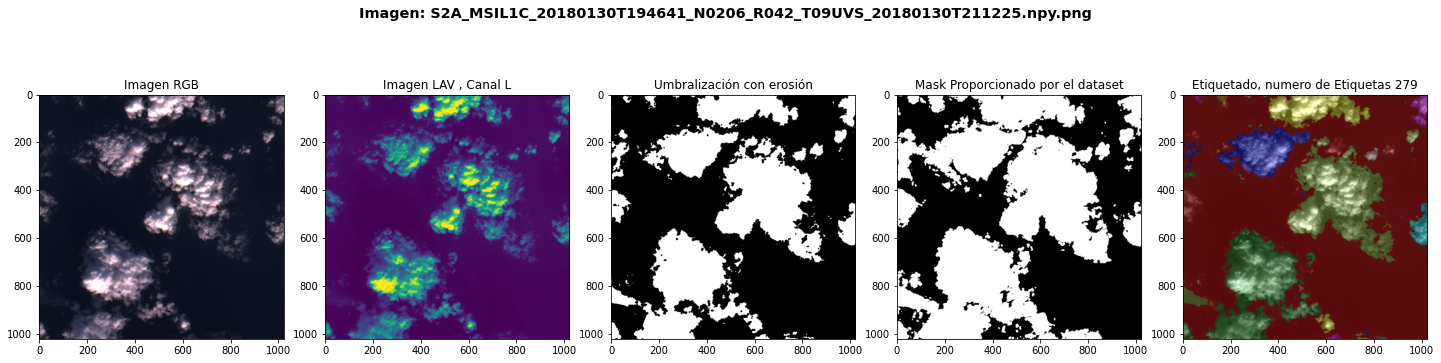

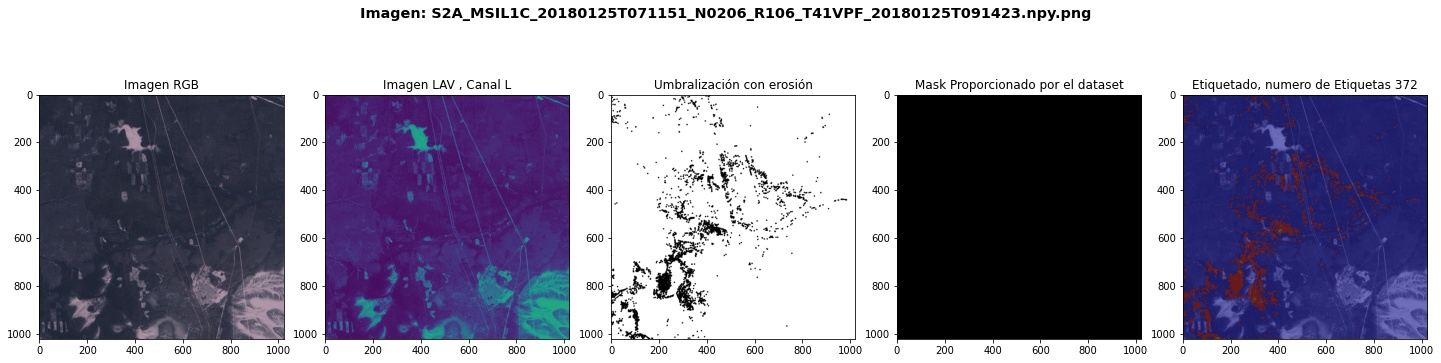

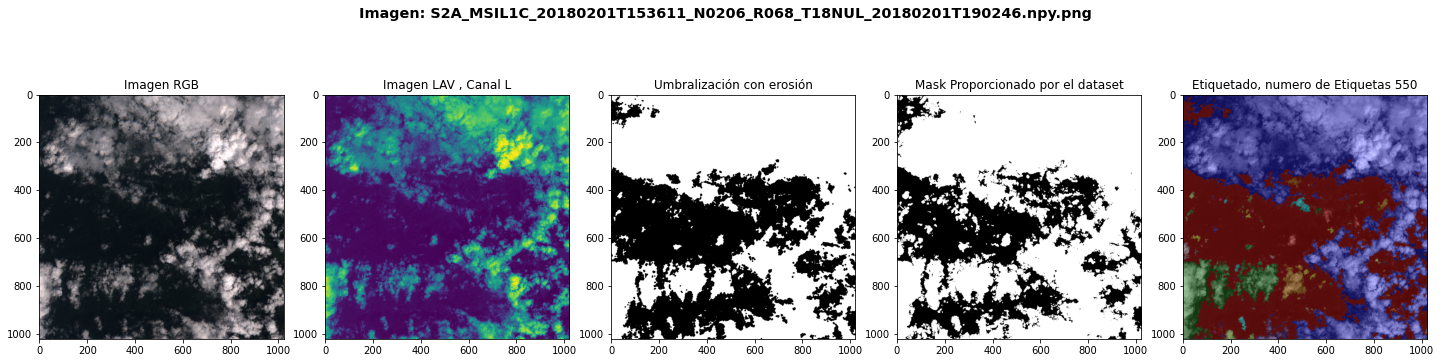

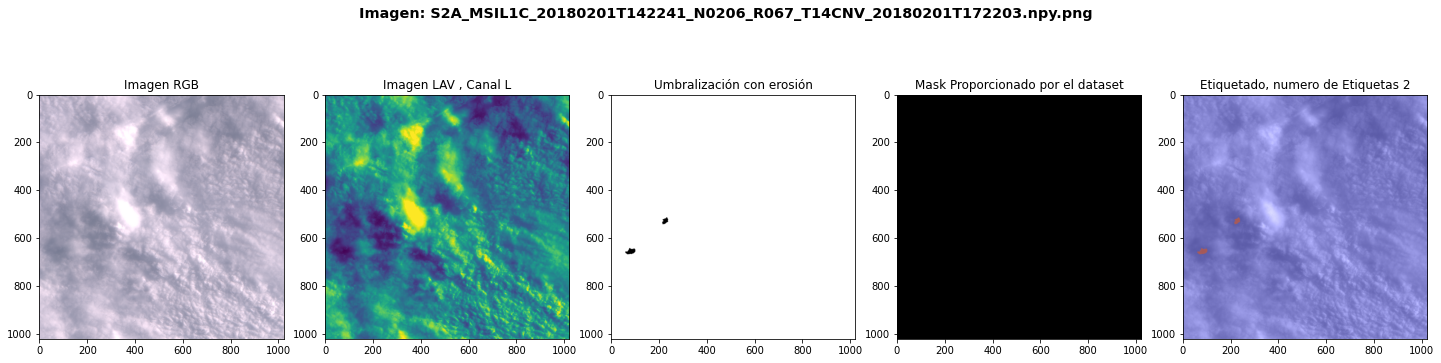

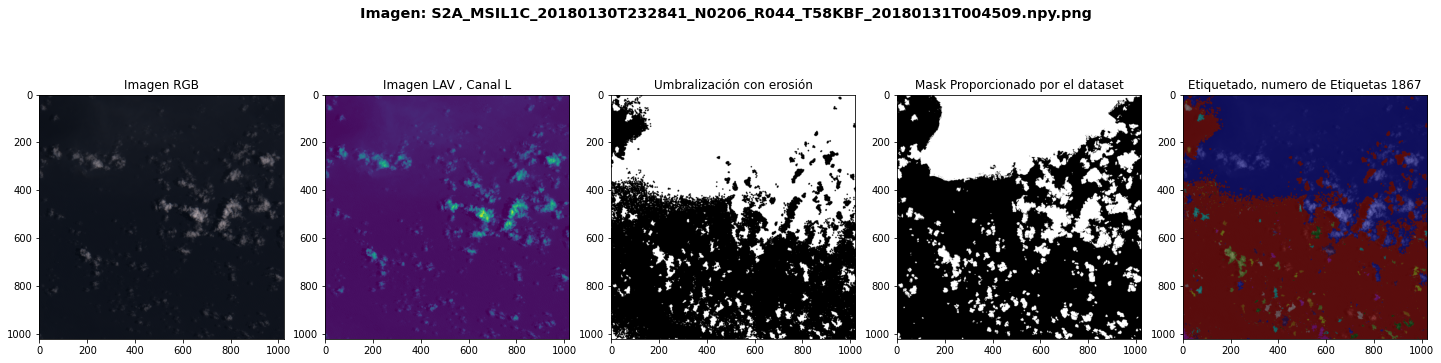

Error in callback <function flush_figures at 0x7fc5191f5f80> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
for i in range(0,round(Classification_tags.size/2)): 
  img = image.load_img(f'/content/drive/MyDrive/ProyectoVision/RGB_Data_JPG/subscenes_RGB/{Classification_tags["subscene"][i][:-4]}.jpg',target_size= (1022,1022))
  pathmask='/content/drive/MyDrive/ProyectoVision/matriz/'+Classification_tags["subscene"][i]
  maskr=np.load(pathmask)
  maskr=maskr[:,:,1]

  X = image.img_to_array(img)
  X = np.expand_dims(X,axis = 0)
  images = np.vstack([X])
  val = RGB_model.predict (images)
  if val == 1:
    pathsubscene='/content/drive/MyDrive/ProyectoVision/subscenes/'+ Classification_tags["subscene"][i]
    subscene=np.load(pathsubscene)
    #Se transforma para que la imagen sea RGB
    RGB=subscene[...,[3,2,1]]
    #Se transforma la imagen de RGB a LAB
    img_lab  = cv2.cvtColor(RGB, cv2.COLOR_RGB2LAB)
    # fig, ((ax1) ) = plt.subplots(1,1 , figsize=(10, 5))
    # ax1.set_title("Imagen LAB")
    # ax1.imshow(img_lab , cmap="gray" )
    #Se selecciona canal L 
    img_L = img_lab[:,:,0]
    img_A =  img_lab[:,:,1]
    img_B = img_lab[:,:,2]
    channelselect=img_L
    channelselect = cv2.normalize(channelselect, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    # print(img_lab.shape)
    # fig, ((ax1,ax2) ) = plt.subplots(1,2 , figsize=(10, 5))
    # ax1.set_title("Imagen Canal L")
    # ax2.set_title("Histograma")
    # ax1.imshow(channelselect, cmap="gray")
    # ax2.hist(channelselect.ravel(),256,[0,256]); plt.show()
    #Se realiza la umbralizacion
    ret,thresh = cv2.threshold(channelselect,8,40,cv2.THRESH_BINARY)
    # fig, ((ax1) ) = plt.subplots(1,1 , figsize=(10, 5))
    # ax1.set_title("Imagen Umbralizada")
    # ax1.imshow(thresh, cmap="gray")
    #crear mascaras para aplicar erosion
    elem1 = morph.disk(3)
    erosion1 = morph.binary_erosion(thresh,elem1)
    labels,num_labels = morph.label(erosion1,background=False,return_num=True,connectivity=1)
    image_label_overlay=color.label2rgb(labels,image=RGB)
    dir=Classification_tags["subscene"][i]
    fig, ((im1,im2,im3,im4,etiquetado) ) = plt.subplots(1,5 , figsize=(20, 10))
    fig.tight_layout()
    im1.set_title("Imagen RGB")
    im2.set_title("Imagen LAV , Canal L")
    im3.set_title("Umbralización con erosión")
    im4.set_title("Mask Proporcionado por el dataset")
    fig.suptitle(f"Imagen: {dir}",y=0.80,fontsize="x-large",fontweight="bold")
    etiquetado.set_title(f"Etiquetado, numero de Etiquetas {num_labels}")
    im1.imshow(RGB)
    im2.imshow(img_L)
    im3.imshow(erosion1 , cmap="gray")
    im4.imshow(maskr , cmap="gray")
    etiquetado.imshow(image_label_overlay)

    
    fig.savefig(f"/content/drive/MyDrive/ProyectoVision/cnn_result_image/{dir}.png")

  else :
      pass

## **tensorFlow 2 - Modelo NIR**

In [ ]:
NIR_model = tf.keras.models.load_model('/content/drive/MyDrive/ProyectoVision/Modelo_NIR/saved_model/my_model')
# Check its architecture
NIR_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1020, 1020, 16)    448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 510, 510, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 508, 508, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 254, 254, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1016064)           0

In [ ]:
# Evaluate the restored model
train = ImageDataGenerator (rescale = 1/255)
validation = ImageDataGenerator (rescale = 1/255)

test_dataset = train.flow_from_directory ('/content/drive/MyDrive/ProyectoVision/test',
                                           target_size = (1022,1022),
                                           batch_size = 5,
                                           class_mode = 'binary')


loss, acc = NIR_model.evaluate(test_dataset, verbose=2)
print('NIR model, accuracy: {:5.2f}%'.format(100 * acc))
print(NIR_model.predict(test_dataset).shape)

Found 102 images belonging to 2 classes.
21/21 - 37s - loss: 0.5279 - accuracy: 0.7549
NIR model, accuracy: 75.49%
(102, 1)


In [ ]:
INFO = {"subscene": [], "Nube" : [], "No_Nube": []}

count = 0
count_nubes = 0
count_no_nubes = 0

path_subscenes_npy = '/content/drive/MyDrive/ProyectoVision/subscenes/'
names = os.listdir(path_subscenes_npy)

for i in names: 
  img = image.load_img(f'/content/drive/MyDrive/ProyectoVision/Modelo_NIR/Subscenes_NIR_jpg/{i[:-4]}.jpg',target_size= (1022,1022))
  X = image.img_to_array(img)
  X = np.expand_dims(X,axis = 0)
  images = np.vstack([X])
  val = NIR_model.predict (images)
  INFO["subscene"].append(f'{i[:-4]}.npy')
  count += 1
  if val == 1:
      # print ("Nube")
      count_nubes += 1
      INFO["Nube"].append(1)
      INFO["No_Nube"].append(0)
  else :
      # print ("No_Nube")
      count_no_nubes += 1
      INFO["Nube"].append(0)
      INFO["No_Nube"].append(1)


In [ ]:
pd.DataFrame.from_dict(INFO)

subscene  Nube  No_Nube
0    S2A_MSIL1C_20180101T010721_N0206_R045_T53HLD_2...     1        0
1    S2A_MSIL1C_20180107T111431_N0206_R137_T31VEE_2...     1        0
2    S2A_MSIL1C_20180108T104421_N0206_R008_T31TEF_2...     1        0
3    S2A_MSIL1C_20180101T074231_N0206_R049_T37LDJ_2...     1        0
4    S2A_MSIL1C_20180102T084341_N0206_R064_T36TVP_2...     1        0
..                                                 ...   ...      ...
508  S2B_MSIL1C_20181220T033139_N0207_R018_T48SYC_2...     1        0
509  S2B_MSIL1C_20181230T033139_N0207_R018_T48QVH_2...     1        0
510  S2B_MSIL1C_20181224T171359_N0207_R083_T06CWV_2...     1        0
511  S2B_MSIL1C_20181230T015059_N0207_R017_T53TPL_2...     1        0
512  S2B_MSIL1C_20181225T100049_N0207_R093_T20CMR_2...     1        0

[513 rows x 3 columns]

In [ ]:
print(f'Número de imagenes Analizadas {count} \n Número de imagenes con nubes según el modelo {count_nubes} \n Número de imagenes con sin nubes segun el modelo {count_no_nubes} \n Porcentaje de nubes {count_nubes/count * 100} ')

Número de imagenes Analizadas 513 
 Número de imagenes con nubes según el modelo 511 
 Número de imagenes con sin nubes segun el modelo 2 
 Porcentaje de nubes 99.61013645224172 


In [ ]:
df = pd.DataFrame.from_dict(INFO)
df.to_csv('/content/drive/MyDrive/ProyectoVision/Modelo_NIR/Clasificicación_modelo_NIR.csv', sep = ";")

In [ ]:
for i in range(0,round(Classification_tags.size/2)): 
  img = image.load_img(f'/content/drive/MyDrive/ProyectoVision/Modelo_NIR/Subscenes_NIR_jpg/{Classification_tags["subscene"][i][:-4]}.jpg',target_size= (1022,1022))
  pathmask='/content/drive/MyDrive/ProyectoVision/matriz/'+Classification_tags["subscene"][i]
  maskr=np.load(pathmask)
  maskr=maskr[:,:,1]

  X = image.img_to_array(img)
  X = np.expand_dims(X,axis = 0)
  images = np.vstack([X])
  val = NIR_model.predict (images)
  if val == 1:
    pathsubscene='/content/drive/MyDrive/ProyectoVision/subscenes/'+ Classification_tags["subscene"][i]
    subscene=np.load(pathsubscene)
    #Se transforma para que la imagen sea RGB
    RGB=subscene[...,[3,2,1]]
    #Se transforma la imagen de RGB a LAB
    img_lab  = cv2.cvtColor(RGB, cv2.COLOR_RGB2LAB)
    # fig, ((ax1) ) = plt.subplots(1,1 , figsize=(10, 5))
    # ax1.set_title("Imagen LAB")
    # ax1.imshow(img_lab , cmap="gray" )
    #Se selecciona canal L 
    img_L = img_lab[:,:,0]
    img_A =  img_lab[:,:,1]
    img_B = img_lab[:,:,2]
    channelselect=img_L
    channelselect = cv2.normalize(channelselect, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    # print(img_lab.shape)
    # fig, ((ax1,ax2) ) = plt.subplots(1,2 , figsize=(10, 5))
    # ax1.set_title("Imagen Canal L")
    # ax2.set_title("Histograma")
    # ax1.imshow(channelselect, cmap="gray")
    # ax2.hist(channelselect.ravel(),256,[0,256]); plt.show()
    #Se realiza la umbralizacion
    ret,thresh = cv2.threshold(channelselect,8,40,cv2.THRESH_BINARY)
    # fig, ((ax1) ) = plt.subplots(1,1 , figsize=(10, 5))
    # ax1.set_title("Imagen Umbralizada")
    # ax1.imshow(thresh, cmap="gray")
    #crear mascaras para aplicar erosion
    elem1 = morph.disk(3)
    erosion1 = morph.binary_erosion(thresh,elem1)
    labels,num_labels = morph.label(erosion1,background=False,return_num=True,connectivity=1)
    image_label_overlay=color.label2rgb(labels,image=RGB)
    dir=Classification_tags["subscene"][i]
    fig, ((im1,im2,im3,im4,etiquetado) ) = plt.subplots(1,5 , figsize=(20, 10))
    fig.tight_layout()
    im1.set_title("Imagen RGB")
    im2.set_title("Imagen LAV , Canal L")
    im3.set_title("Umbralización con erosión")
    im4.set_title("Mask Proporcionado por el dataset")
    fig.suptitle(f"Imagen: {dir}",y=0.80,fontsize="x-large",fontweight="bold")
    etiquetado.set_title(f"Etiquetado, numero de Etiquetas {num_labels}")
    im1.imshow(RGB)
    im2.imshow(img_L)
    im3.imshow(erosion1 , cmap="gray")
    im4.imshow(maskr , cmap="gray")
    etiquetado.imshow(image_label_overlay)

    
    fig.savefig(f"/content/drive/MyDrive/ProyectoVision/cnn_result_image_NIR/{dir}.png")

  else :
      pass